In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Load and preprocess data
data = pd.read_csv("/content/hour.csv")
data = data.drop(['instant', 'casual', 'registered'], axis=1)
data['date'] = pd.to_datetime(data['dteday'])
data = data.drop('dteday', axis=1)

In [9]:
# Create lag 1 feature
data['cnt_lag1'] = data['cnt'].shift(1).fillna(0)


In [10]:
# Create dummy variables
dummy_vars = ['season', 'mnth', 'weekday', 'weathersit']
data = pd.get_dummies(data, columns=dummy_vars)

In [11]:
# Label encoding for specific variables
data['yr'] = data['yr'].astype(int)
data['holiday'] = data['holiday'].astype(int)
data['workingday'] = data['workingday'].astype(int)


In [12]:
# Split data into features and target
features = data.columns.drop(['cnt', 'date'])
X = data[features]
y = data['cnt']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [13]:
# Scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Scale target variable
y_scaler = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))


In [14]:
# Reshape input data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [15]:
# Define and compile the model
model = Sequential([
    LSTM(50, input_shape=(1, X_train_scaled.shape[1]), return_sequences=True),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.002), loss='mse', metrics=['mae'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# Train the model
epochs = 5
history = model.fit(X_train_reshaped, y_train_scaled, epochs=epochs, batch_size=1, verbose=1, shuffle=False)

# Make predictions
predictions_lstm = model.predict(X_test_reshaped)
predictions_lstm = y_scaler.inverse_transform(predictions_lstm)


Epoch 1/5
13903/13903 ━━━━━━━━━━━━━━━━━━━━ 69s 5ms/step - loss: 0.0193 - mae: 0.0972
Epoch 2/5
13903/13903 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - loss: 0.0177 - mae: 0.0932
Epoch 3/5
13903/13903 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - loss: 0.0161 - mae: 0.0897
Epoch 4/5
13903/13903 ━━━━━━━━━━━━━━━━━━━━ 83s 5ms/step - loss: 0.0136 - mae: 0.0828
Epoch 5/5
13903/13903 ━━━━━━━━━━━━━━━━━━━━ 84s 5ms/step - loss: 0.0131 - mae: 0.0814
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [18]:
# Calculate RMSE
lstm_rmse_value = np.sqrt(np.mean((y_test.values - predictions_lstm.flatten())**2))
print(f"Root Mean Squared Error (RMSE) for LSTM: {lstm_rmse_value}")

Root Mean Squared Error (RMSE) for LSTM: 77.40352938447795


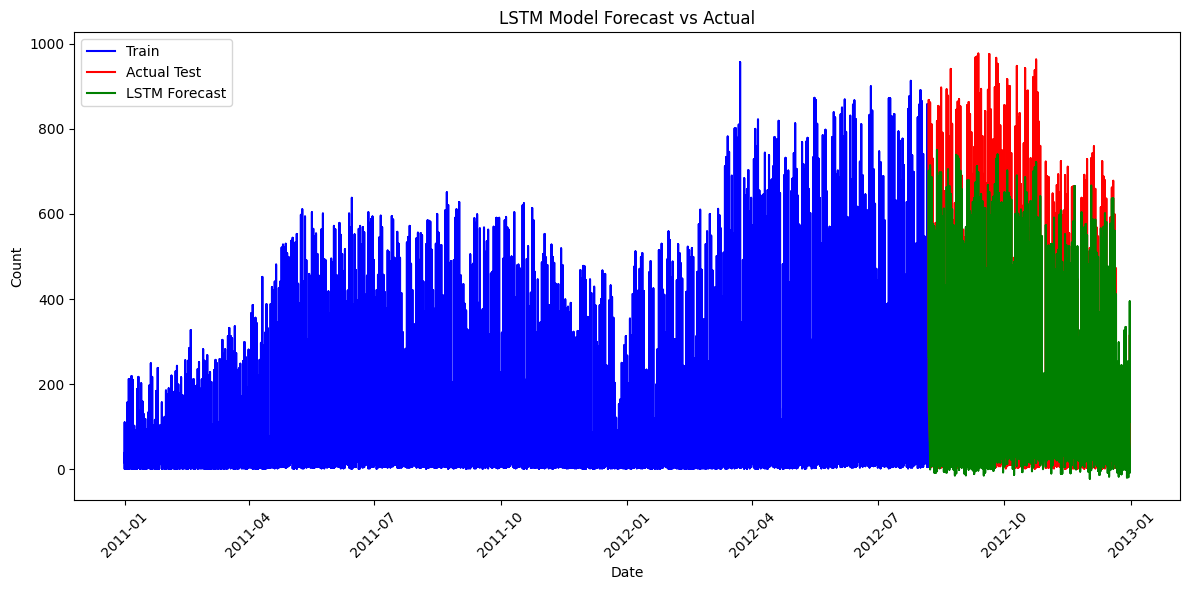

In [19]:
# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(data['date'][:len(y_train)], y_train, label='Train', color='blue')
plt.plot(data['date'][len(y_train):], y_test, label='Actual Test', color='red')
plt.plot(data['date'][len(y_train):], predictions_lstm, label='LSTM Forecast', color='green')
plt.title('LSTM Model Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()